In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load in annotations

df_images = pd.read_csv('list.txt', delim_whitespace=True, comment="#", header=None, 
                        names=["filename", "class_id", "species", "breed_id"])
df_images.head()

/tmp/ipykernel_921770/892805134.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_images = pd.read_csv('list.txt', delim_whitespace=True, comment="#", header=None,


,filename,class_id,species,breed_id
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [3]:
# Add animal_name column to describe images

df_images["animal_name"] = df_images["filename"].str.replace(r'_\d+$', '', regex=True)
df_images.tail()

,filename,class_id,species,breed_id,animal_name
7344,yorkshire_terrier_96,37,2,25,yorkshire_terrier
7345,yorkshire_terrier_97,37,2,25,yorkshire_terrier
7346,yorkshire_terrier_98,37,2,25,yorkshire_terrier
7347,yorkshire_terrier_99,37,2,25,yorkshire_terrier
7348,yorkshire_terrier_9,37,2,25,yorkshire_terrier


In [4]:
# Had problems uploading the images as a folder, so used a zip file and need to uncompress

# !unzip images.zip -d images

In [5]:
# Create a function to load in images

from PIL import Image
import os

def load_image(base_filename, img_dir="images"): 
    img_path = os.path.join(img_dir, f"{base_filename}.jpg") 
    try:
        with Image.open(img_path) as img:
            return img.copy()
    except Exception as e:
        print(f"Error opening {img_path}: {e}")
        return None

df_images['image'] = df_images['filename'].apply(lambda x: load_image(x, img_dir='images/images'))

In [6]:
df_images.head()

,filename,class_id,species,breed_id,animal_name,image
0,Abyssinian_100,1,1,1,Abyssinian,<PIL.Image.Image image mode=RGB size=394x500 a...
1,Abyssinian_101,1,1,1,Abyssinian,<PIL.Image.Image image mode=RGB size=450x313 a...
2,Abyssinian_102,1,1,1,Abyssinian,<PIL.Image.Image image mode=RGB size=500x465 a...
3,Abyssinian_103,1,1,1,Abyssinian,<PIL.Image.Image image mode=RGB size=500x351 a...
4,Abyssinian_104,1,1,1,Abyssinian,<PIL.Image.Image image mode=RGB size=600x363 a...


### Begin building CNN model

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

In [11]:
# Create a function to resize images and save in X array

target_size = (224, 224)
def process_image(img, target_size):
    img = img.convert("RGB")
    img = img.resize(target_size)
    arr = np.array(img).astype("float32") / 255.0
    return arr

X = np.array([process_image(img, target_size) for img in df_images['image']])

In [9]:
# Save images classes as y, subtracting 1 for zero-indexing

y = df_images['class_id'].astype(int) - 1

In [10]:
# One hot encoding class ids 

num_classes = len(np.unique(y))
y_categorical = keras.utils.to_categorical(y, num_classes=num_classes)

In [12]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42
)

In [15]:
# Build CNN architecture

model = Sequential([
    Input(shape=(224, 224, 3)),
    # Convolutional Block 1
    Conv2D(64, kernel_size=(3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    
    # Convolutional Block 2
    Conv2D(128, kernel_size=(3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    
    # Convolutional Block 3
    Conv2D(256, kernel_size=(3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

2025-04-17 11:11:34.916051: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
history = model.fit(X_train, y_train, 
                    validation_split=0.2,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
74/74 [==============================] - 75s 984ms/step - loss: 15.9045 - accuracy: 0.0298 - val_loss: 10.1686 - val_accuracy: 0.0221
Epoch 2/50
74/74 [==============================] - 73s 992ms/step - loss: 3.6354 - accuracy: 0.0242 - val_loss: 7.3958 - val_accuracy: 0.0272
Epoch 3/50
74/74 [==============================] - 76s 1s/step - loss: 3.6134 - accuracy: 0.0253 - val_loss: 9.2005 - val_accuracy: 0.0204
Epoch 4/50
74/74 [==============================] - 73s 992ms/step - loss: 3.6181 - accuracy: 0.0281 - val_loss: 8.6468 - val_accuracy: 0.0221
Epoch 5/50
74/74 [==============================] - 72s 972ms/step - loss: 3.6124 - accuracy: 0.0296 - val_loss: 5.6023 - val_accuracy: 0.0170
Epoch 6/50
74/74 [==============================] - 70s 951ms/step - loss: 3.6106 - accuracy: 0.0283 - val_loss: 3.9743 - val_accuracy: 0.0153
Epoch 7/50
74/74 [==============================] - 70s 946ms/step - loss: 3.6106 - accuracy: 0.0281 - val_loss: 3.6647 - val_accuracy: 0.0162


In [20]:
# Evaluate classification accuracy on test set

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

46/46 [==============================] - 5s 113ms/step - loss: 3.6191 - accuracy: 0.0265
Test accuracy: 0.026530612260103226


46/46 [==============================] - 6s 120ms/step


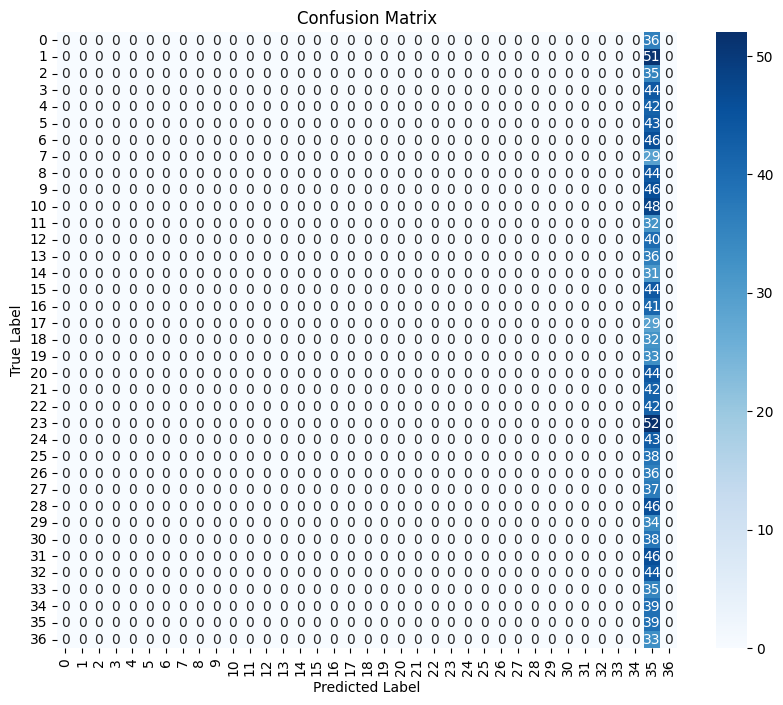

In [21]:
# Plot confusion matrix

from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Try a model using pre-trained network

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import Input

In [23]:
# Load the pre-trained VGG16 model without the top classifier layers

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

model2 = Sequential([
    Input(shape=(224, 224, 3)),
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [25]:
# Fit the model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[reduce_lr, early_stop],
    shuffle=True,
    verbose=1
)


Epoch 1/20
184/184 [==============================] - 100s 543ms/step - loss: 3.6116 - accuracy: 0.0257 - val_loss: 3.6191 - val_accuracy: 0.0197 - lr: 0.0010
Epoch 2/20
184/184 [==============================] - 97s 530ms/step - loss: 3.6113 - accuracy: 0.0291 - val_loss: 3.6191 - val_accuracy: 0.0197 - lr: 0.0010
Epoch 3/20
184/184 [==============================] - 98s 532ms/step - loss: 3.6111 - accuracy: 0.0291 - val_loss: 3.6191 - val_accuracy: 0.0197 - lr: 0.0010
Epoch 4/20
107/184 [================>.............] - ETA: 38s - loss: 3.6106 - accuracy: 0.0295

KeyboardInterrupt: 

What is going on? Trying out the original model trained on my laptop

In [26]:
target_size = (128, 128)
def process_image(img, target_size):
    img = img.convert("RGB")
    img = img.resize(target_size)
    arr = np.array(img).astype("float32") / 255.0
    return arr

X = np.array([process_image(img, target_size) for img in df_images['image']])

In [27]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42
)

In [30]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

In [31]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [32]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
147/147 [==============================] - 8s 50ms/step - loss: 3.6809 - accuracy: 0.0315 - val_loss: 3.5841 - val_accuracy: 0.0646
Epoch 2/10
147/147 [==============================] - 7s 46ms/step - loss: 3.5061 - accuracy: 0.0693 - val_loss: 3.4526 - val_accuracy: 0.0740
Epoch 3/10
147/147 [==============================] - 7s 46ms/step - loss: 3.2513 - accuracy: 0.1252 - val_loss: 3.2546 - val_accuracy: 0.1148
Epoch 4/10
147/147 [==============================] - 7s 46ms/step - loss: 2.8613 - accuracy: 0.2145 - val_loss: 3.2713 - val_accuracy: 0.1165
Epoch 5/10
147/147 [==============================] - 7s 46ms/step - loss: 2.3090 - accuracy: 0.3570 - val_loss: 3.3127 - val_accuracy: 0.1293
Epoch 6/10
147/147 [==============================] - 7s 46ms/step - loss: 1.7613 - accuracy: 0.4965 - val_loss: 3.6889 - val_accuracy: 0.1259
Epoch 7/10
147/147 [==============================] - 7s 46ms/step - loss: 1.3265 - accuracy: 0.6217 - val_loss: 3.7998 - val_accuracy: 0.1276

In [33]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

46/46 [==============================] - 1s 11ms/step - loss: 4.5056 - accuracy: 0.1327
Test accuracy: 0.13265305757522583


46/46 [==============================] - 1s 10ms/step


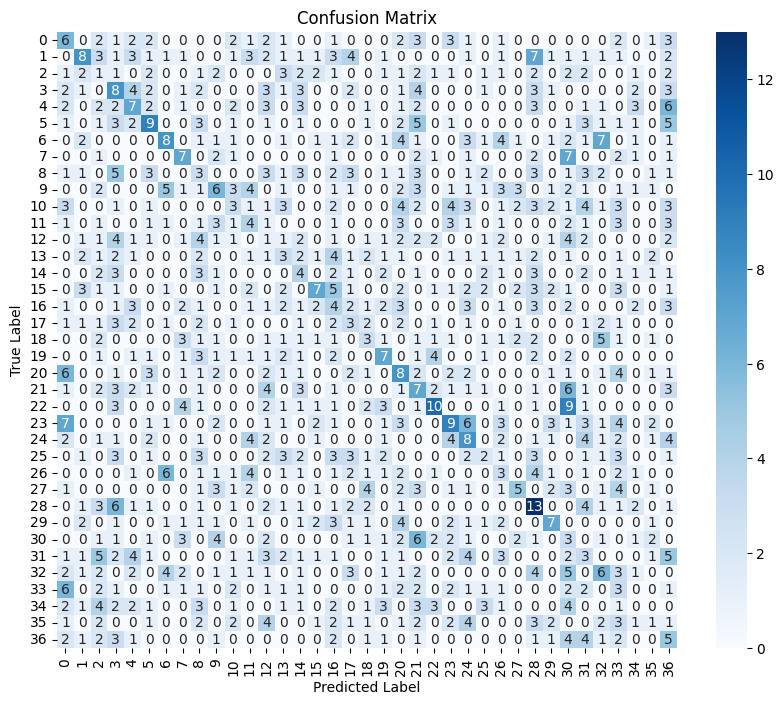

In [34]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()